# Benchmark Analysis - H4

In [63]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [64]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [65]:
matplotlib.style.use('seaborn-v0_8')  

In [66]:
root_dir = '/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES'

In [67]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [68]:
plot_save_dir = './plots/h4'

## Utils 

In [69]:
def get_path(*entries):
    return os.path.join(*entries)

In [70]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [71]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [72]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)
    
    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [73]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [74]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [75]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [76]:
def bytes_per_second_data_algo(compiler_location:str,compiler_name:str,benchmark_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{benchmark_name}__Default.csv',COMP=compiler_name,include_bytes_per_second=True)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','real_time'])

    # calc  Mbytes/s
    df[f'{compiler_name}'] = df['bytes_per_second'] * pow(10,-6) # 
    df = df.drop(columns=['bytes_per_second'])
    
    return df

# H4
> Different compilers/backends may fallback to sequential algorithms, leading to better performance.

## `b4_1_merge_cutoff_wrapper_par`

### Time Comparison - `b4_1_merge_cutoff_wrapper_par`


Check how the runtime without constraining the threads develops with increasing input size

In [77]:
def get_b4_1_merge_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_1_merge_cutoff_wrapper_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_1_merge_cutoff_wrapper_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_1_merge_data_algo(*x) for x in instances]


# merge for plotting 
b4_1_merge_time_merged = pd.merge(*data, on='n')

b4_1_merge_time_merged

,GCC(TBB),n,NVC(OMP)
0,1.268580e+03,4,6.791540e+03
1,1.277860e+03,8,7.157150e+03
2,1.294990e+03,16,7.243580e+03
3,1.335450e+03,32,7.809500e+03
4,1.429700e+03,64,7.683550e+03
5,1.576750e+03,128,7.672150e+03
6,1.932060e+03,256,8.441930e+03
7,2.511870e+03,512,9.091010e+03
8,7.404880e+03,1024,1.131230e+04
9,1.195750e+04,2048,1.351480e+04


### Strong Scaling - `b4_1_merge_cutoff_wrapper_par`
 
1 Million fixed input size with threads 1-64

In [78]:
def get_b4_1_merge_cutoff_wrapper_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_1_merge_cutoff_wrapper_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## b4_1_merge_cutoff_wrapper_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_1_merge_cutoff_wrapper_par',
                                               [1,2,4,8,16,32],
                                               COMP=compiler_name
                                            )
    
    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_1_merge_cutoff_wrapper_scaling_algo(*x) for x in instances]

b4_1_merge_cutoff_wrapper_strong_scaling_merged = pd.merge(*data, on='threads')


b4_1_merge_cutoff_wrapper_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.843823,0.835543
1,2,1.190393,0.873596
2,4,1.504908,0.905237
3,8,1.717758,0.922703
4,16,1.803606,0.929198
5,32,1.726354,0.914957


In [79]:
# efficiency b4_4_set_difference_cutoff_intersected_par
b4_1_merge_cutoff_wrapper_efficiency = b4_1_merge_cutoff_wrapper_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_1_merge_cutoff_wrapper_efficiency[f'{compiler_name}'] = b4_1_merge_cutoff_wrapper_efficiency[f'{compiler_name}'] / b4_1_merge_cutoff_wrapper_efficiency['threads']
    

b4_1_merge_cutoff_wrapper_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.843823,0.835543
1,2,0.595197,0.436798
2,4,0.376227,0.226309
3,8,0.214720,0.115338
4,16,0.112725,0.058075
5,32,0.053949,0.028592


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/2804720403.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


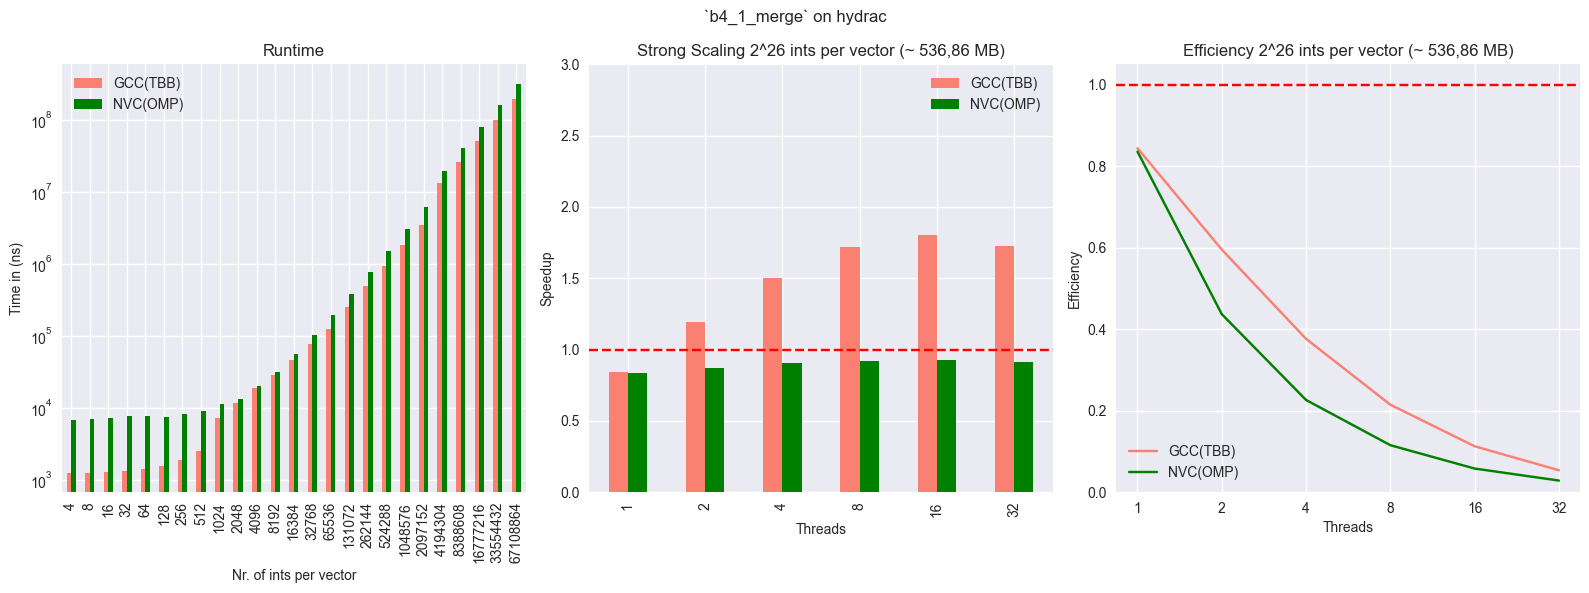

In [80]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b4_1_merge_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints per vector')
ax_1.set_title('Runtime')



# plot strong scaling
ax_2 = b4_1_merge_cutoff_wrapper_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints per vector (~ 536,86 MB)')






# plot efficiency
ax_3 = b4_1_merge_cutoff_wrapper_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                             ax=axes[2]
                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints per vector (~ 536,86 MB)')



fig.suptitle("`b4_1_merge` on hydrac")

fig.tight_layout()

plot("`b4_1_merge` hydrac")

### Mbytes/Seconds

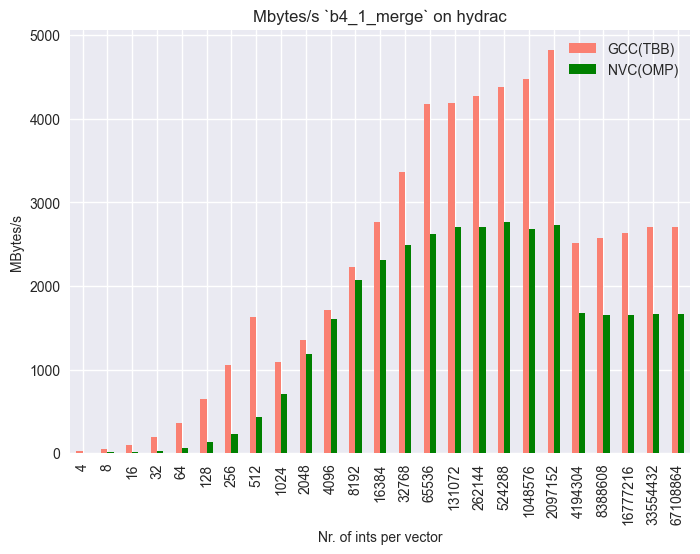

In [81]:
benchmark_name= 'b4_1_merge_cutoff_wrapper_par'
instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

b4_1_mbytes_sec_data = pd.merge(*data, on='n')

# plot mbytes
b4_1_mbytes_sec_data.plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR]
                                                    )


plt.ylabel('MBytes/s')
plt.xlabel('Nr. of ints per vector')
plt.title('Mbytes/s `b4_1_merge` on hydrac')


plot('`b4_1_merge` Mbytes_s on hydrac')

## `b4_2_stable_sort`


### Time Comparison - `b4_2_stable_sort_cutoff_already_sorted_par`

Check how the runtime without constraining the threads develops with increasing input size

In [82]:
def get_b4_2_stable_sort_cutoff_already_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_already_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_already_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_already_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_already_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_already_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,1.296630e+03,4,19181.0
1,1.311020e+03,8,25787.1
2,1.378560e+03,16,34668.3
3,1.470670e+03,32,41292.4
4,1.686370e+03,64,42380.6
5,2.154700e+03,128,40205.3
6,3.069410e+03,256,42757.3
7,8.163960e+03,512,42946.3
8,1.205850e+04,1024,44686.4
9,1.621030e+04,2048,48701.5


### Time Comparison - `b4_2_stable_sort_cutoff_decrement_sorted_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [83]:
def b4_2_stable_sort_cutoff_decrement_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_decrement_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_2_stable_sort_cutoff_decrement_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_decrement_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_decrement_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,1.295560e+03,4,19142.0
1,1.309400e+03,8,24419.9
2,1.377150e+03,16,32832.9
3,1.466350e+03,32,41214.0
4,1.678610e+03,64,43514.3
5,2.155140e+03,128,41959.9
6,3.062080e+03,256,44464.3
7,8.229640e+03,512,42295.9
8,1.203640e+04,1024,43510.6
9,1.609480e+04,2048,50418.1


### Time Comparison - `b4_2_stable_sort_cutoff_not_sorted_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [84]:
def b4_2_stable_sort_cutoff_not_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_not_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_not_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_2_stable_sort_cutoff_not_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_not_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_not_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,1.291780e+03,4,18940.7
1,1.307870e+03,8,22422.1
2,1.368580e+03,16,29353.4
3,1.464110e+03,32,36452.5
4,1.678940e+03,64,36134.0
5,2.148990e+03,128,36947.0
6,3.059670e+03,256,36643.0
7,8.284260e+03,512,35329.0
8,1.209650e+04,1024,37594.3
9,1.611440e+04,2048,43741.3


### Strong Scaling - `b4_2_stable_sort_cutoff_already_sorted_par`

In [85]:
def get_b4_2_stable_sort_cutoff_already_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_already_sorted_seq__Default.csv',
                                            COMP=compiler_name)
    
    
    ## b4_2_stable_sort_cutoff_already_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_already_sorted_par',
                                               [1,2,4,8,16,32],
                                               COMP=compiler_name
                                            )
    
    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_already_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,2.921615,0.268745
1,2,5.788979,0.499716
2,4,11.427809,0.923672
3,8,22.546904,1.646260
4,16,44.184090,2.381055
5,32,76.932686,2.474429


In [86]:
# efficiency b4_2_stable_sort_cutoff_already_sorted_par
b4_2_stable_sort_cutoff_already_sorted_efficiency = b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_already_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_already_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_already_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_already_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,2.921615,0.268745
1,2,2.894489,0.249858
2,4,2.856952,0.230918
3,8,2.818363,0.205783
4,16,2.761506,0.148816
5,32,2.404146,0.077326


### Strong Scaling - `b4_2_stable_sort_cutoff_decrement_sorted_par`

1 Million fixed input size with threads 1-64

In [87]:
def get_b4_2_stable_sort_cutoff_decrement_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_decrement_sorted_seq__Default.csv',
                                            COMP=compiler_name)
    
    
    ## b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_decrement_sorted_par',
                                               [1,2,4,8,16,32],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_decrement_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.033766,0.349446
1,2,2.020955,0.649341
2,4,3.884133,1.138012
3,8,15.564496,2.035805
4,16,36.623884,2.943263
5,32,73.930899,3.120979


In [88]:
# efficiency b4_2_stable_sort_cutoff_decrement_sorted_par
b4_2_stable_sort_cutoff_decrement_sorted_efficiency = b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_decrement_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_decrement_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_decrement_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_decrement_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.033766,0.349446
1,2,1.010477,0.324670
2,4,0.971033,0.284503
3,8,1.945562,0.254476
4,16,2.288993,0.183954
5,32,2.310341,0.097531


### Strong Scaling - `b4_2_stable_sort_cutoff_not_sorted_par`

1 Million fixed input size with threads 1-64

In [89]:
def get_b4_2_stable_sort_cutoff_not_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_not_sorted_seq__Default.csv',
                                            COMP=compiler_name)
    
    
    ## b4_2_stable_sort_cutoff_not_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_not_sorted_par',
                                               [1,2,4,8,16,32],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_not_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.913880,7.485647
1,2,1.809454,8.997065
2,4,3.589930,9.955896
3,8,6.973287,10.502478
4,16,52.496518,10.852326
5,32,142.842017,10.697753


In [90]:
# efficiency b4_2_stable_sort_cutoff_not_sorted_par
b4_2_stable_sort_cutoff_not_sorted_efficiency = b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_not_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_not_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_not_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_not_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.913880,7.485647
1,2,0.904727,4.498533
2,4,0.897483,2.488974
3,8,0.871661,1.312810
4,16,3.281032,0.678270
5,32,4.463813,0.334305


### Plotting

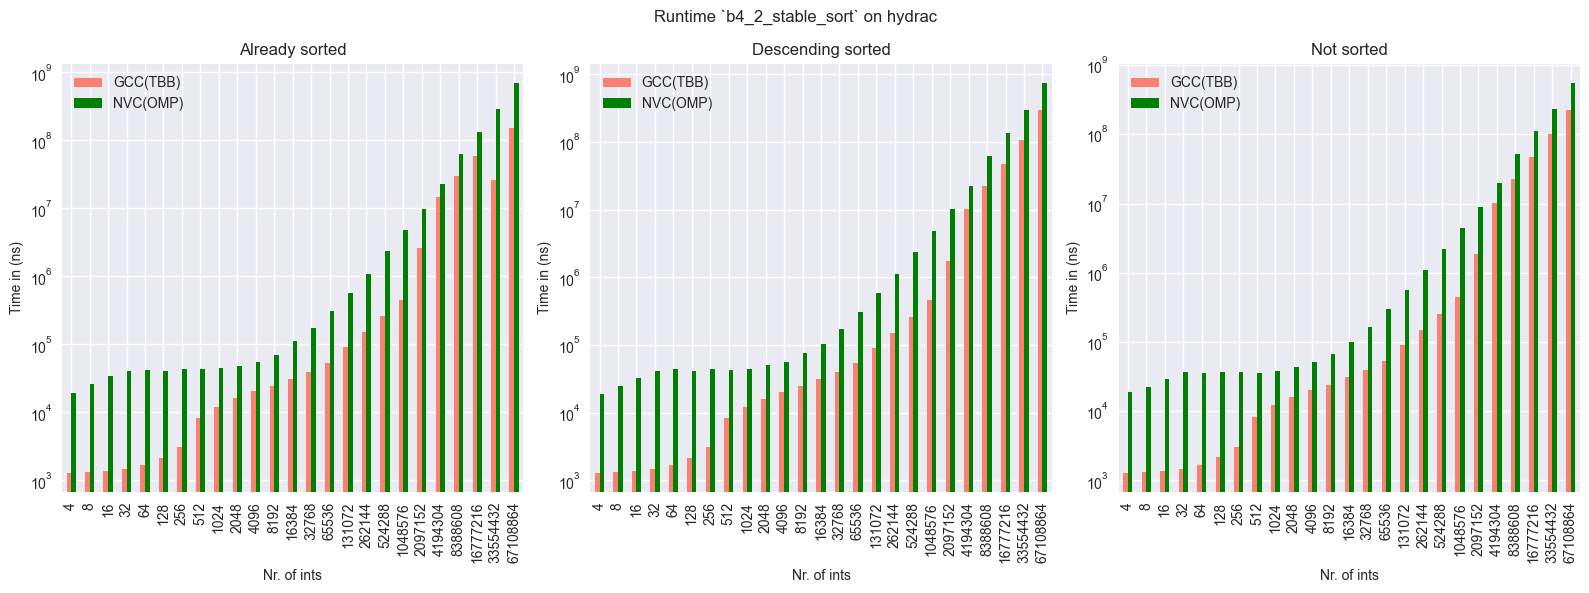

In [91]:
### Runtime

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')

fig.suptitle("Runtime `b4_2_stable_sort` on hydrac")

fig.tight_layout()

plot("`b4_2_stable_sort` Runtime on hydrac")


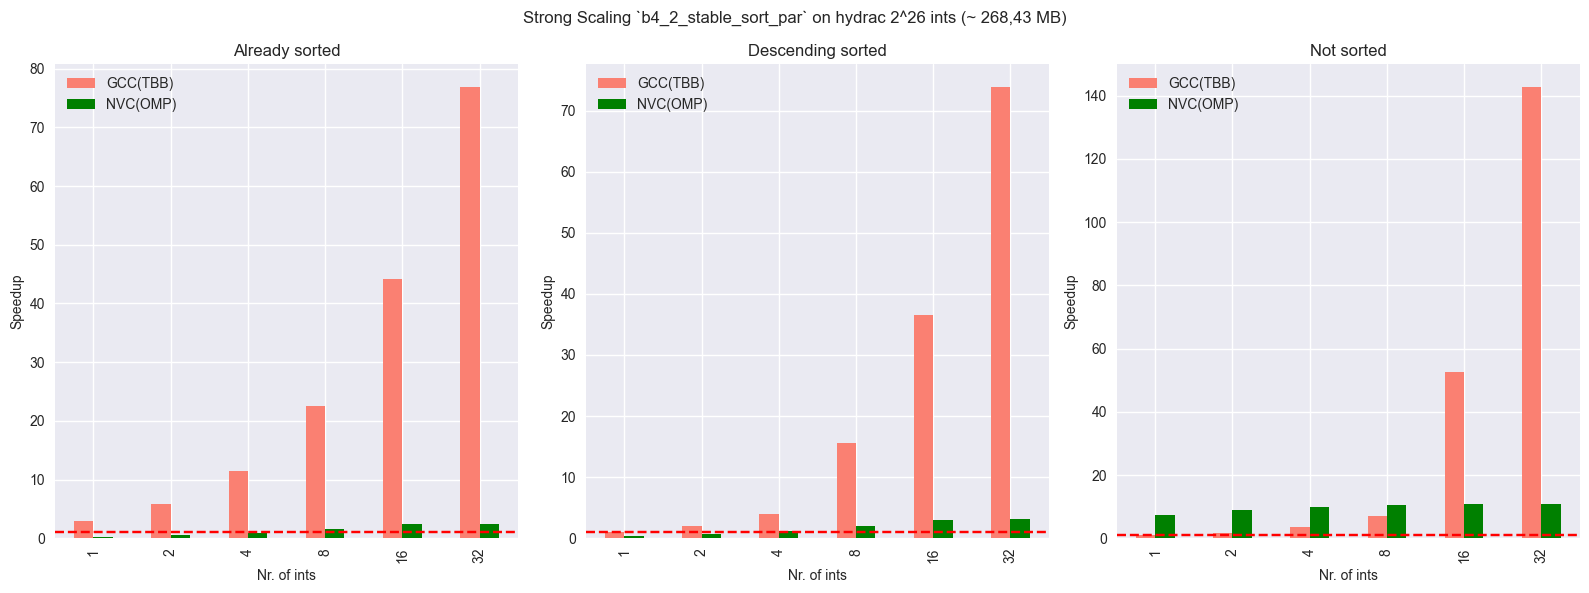

In [92]:
## stable sort strong scaling graphs


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')
ax_1.axhline(y=1,color='r', linestyle='--')


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')
ax_2.axhline(y=1,color='r', linestyle='--')


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')
ax_3.axhline(y=1,color='r', linestyle='--')

fig.suptitle("Strong Scaling `b4_2_stable_sort_par` on hydrac 2^26 ints (~ 268,43 MB)")

fig.tight_layout()

plot("`b4_2_stable_sort` Strong Scaling on hydrac 2^26 ints (~ 268,43 MB)")


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/3379749160.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/3379749160.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/3379749160.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


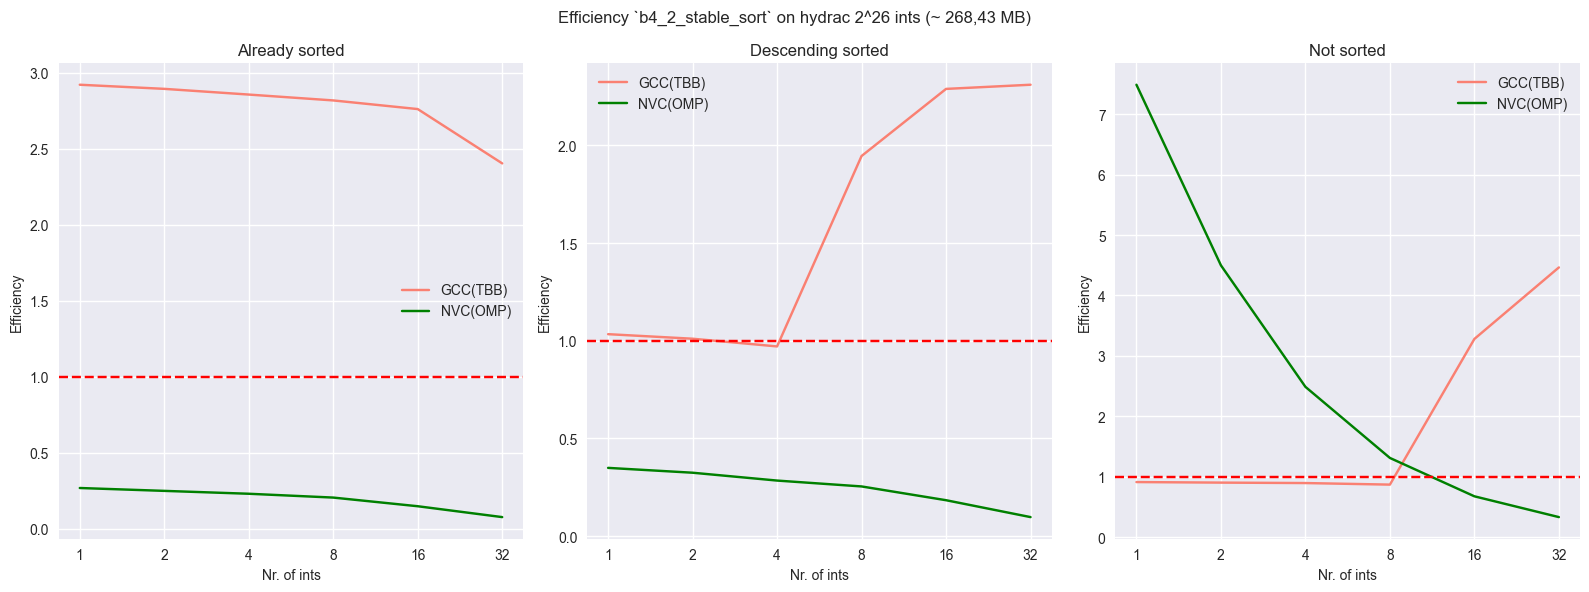

In [93]:
### efficiency stable sort

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')
ax_1.axhline(y=1,color='r', linestyle='--')

#ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')
ax_2.axhline(y=1,color='r', linestyle='--')

#ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')
ax_3.axhline(y=1,color='r', linestyle='--')



ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


fig.suptitle("Efficiency `b4_2_stable_sort` on hydrac 2^26 ints (~ 268,43 MB)")

fig.tight_layout()

plot("`b4_2_stable_sort` Efficiency on hydrac 2^26 ints (~ 268,43 MB)")

### Mbytes/s

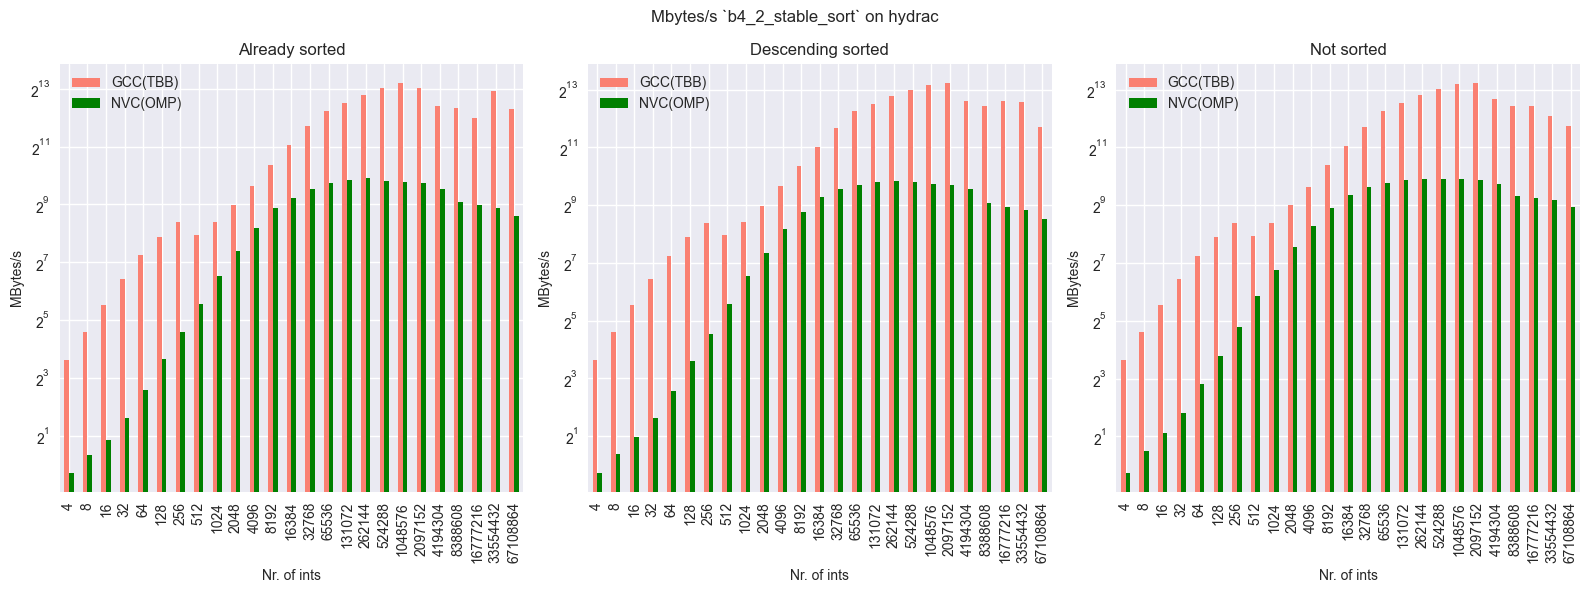

In [94]:
benchmark_names = [
    'b4_2_stable_sort_cutoff_already_sorted_par',
    'b4_2_stable_sort_cutoff_decrement_sorted_par',
    'b4_2_stable_sort_cutoff_not_sorted_par'
]


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

b4_2_mbytes_sec_data = {}

for benchmark_name in benchmark_names:
    # collect data for instances
    data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

    b4_2_mbytes_sec_data[benchmark_name] = pd.merge(*data, on='n')


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))



# plot already sorted
ax_1 = b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_already_sorted_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0]
                                                    )


ax_1.set_yscale('log',base=2)
ax_1.set_ylabel('MBytes/s')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')




# plot decrement_sorted
ax_2 = b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_decrement_sorted_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )


ax_2.set_yscale('log',base=2)
ax_2.set_ylabel('MBytes/s')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')


# plot not_sorted
ax_3 = b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_not_sorted_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[2]
                                                    )

ax_3.set_yscale('log',base=2)
ax_3.set_ylabel('MBytes/s')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')


fig.suptitle("Mbytes/s `b4_2_stable_sort` on hydrac")

fig.tight_layout()

plot("`b4_2_stable_sort` Mbytes_s on hydrac")

## `b4_3_set_union`

### Time Comparison - `b4_3_set_union_cutoff_one_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [95]:
def b4_3_set_union_cutoff_one_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_one_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_one_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_one_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_one_empty_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_one_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,1255.87,4,6.771620e+03
1,1255.02,8,6.790330e+03
2,1255.03,16,7.053960e+03
3,1260.56,32,7.775250e+03
4,1263.84,64,7.304850e+03
5,1272.09,128,7.304160e+03
6,1288.12,256,7.327650e+03
7,1388.61,512,7.495990e+03
8,29885.80,1024,7.669430e+03
9,34881.30,2048,8.801010e+03


### Time Comparison - `b4_3_set_union_cutoff_one_wholly_greater_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [96]:
def b4_3_set_union_cutoff_one_wholly_greater_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_one_wholly_greater_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_one_wholly_greater_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_one_wholly_greater_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_one_wholly_greater_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_one_wholly_greater_time_merged

,GCC(TBB),n,NVC(OMP)
0,1.259000e+03,4,6.690140e+03
1,1.266360e+03,8,6.719240e+03
2,1.282130e+03,16,6.922270e+03
3,1.319700e+03,32,7.377850e+03
4,1.384670e+03,64,7.308140e+03
5,1.533990e+03,128,7.406090e+03
6,1.856770e+03,256,7.875490e+03
7,3.412540e+04,512,8.482660e+03
8,3.820820e+04,1024,9.895500e+03
9,4.493920e+04,2048,1.266740e+04


### Time Comparison - `b4_3_set_union_cutoff_front_overhang_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [97]:
def b4_3_set_union_cutoff_front_overhang_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_front_overhang_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_front_overhang_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_front_overhang_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_front_overhang_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_front_overhang_time_merged

,GCC(TBB),n,NVC(OMP)
0,1.261570e+03,4,6.902140e+03
1,1.267740e+03,8,6.874630e+03
2,1.284880e+03,16,6.942550e+03
3,1.318690e+03,32,7.382180e+03
4,1.384590e+03,64,7.660970e+03
5,1.541590e+03,128,7.762630e+03
6,1.868090e+03,256,7.982840e+03
7,8.129780e+04,512,8.266960e+03
8,8.377130e+04,1024,9.464810e+03
9,8.958820e+04,2048,1.214690e+04


### Strong Scaling - `b4_3_set_union_cutoff_one_empty_par`

1 Million fixed input size with threads 1-64

In [98]:
def get_b4_3_set_union_cutoff_one_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_one_empty_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## b4_3_set_union_cutoff_one_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_one_empty_par',
                                               [1,2,4,8,16,32],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_one_empty_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_one_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_one_empty_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.017123,0.920555
1,2,1.261975,1.161279
2,4,1.410366,1.345311
3,8,1.517189,1.475784
4,16,1.518969,1.467045
5,32,1.422567,1.360097


In [99]:
# efficiency b4_3_set_union_cutoff_one_empty_par
b4_3_set_union_cutoff_one_empty_efficiency = b4_3_set_union_cutoff_one_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_one_empty_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_one_empty_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_one_empty_efficiency['threads']



b4_3_set_union_cutoff_one_empty_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.017123,0.920555
1,2,0.630987,0.580639
2,4,0.352592,0.336328
3,8,0.189649,0.184473
4,16,0.094936,0.091690
5,32,0.044455,0.042503


### Strong Scaling - `b4_3_set_union_cutoff_one_wholly_greater_par`

1 Million fixed input size with threads 1-64

In [100]:
def get_b4_3_set_union_cutoff_one_wholly_greater_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_one_wholly_greater_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## b4_3_set_union_cutoff_one_wholly_greater_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_one_wholly_greater_par',
                                               [1,2,4,8,16,32],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_one_wholly_greater_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.270181,0.950106
1,2,1.588775,1.062033
2,4,1.800835,1.124458
3,8,1.902696,1.148286
4,16,1.851858,1.154842
5,32,1.822824,1.114019


In [101]:

# efficiency b4_3_set_union_cutoff_one_wholly_greater_par
b4_3_set_union_cutoff_one_wholly_greater_efficiency = b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_one_wholly_greater_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_one_wholly_greater_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_one_wholly_greater_efficiency['threads']



b4_3_set_union_cutoff_one_wholly_greater_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.270181,0.950106
1,2,0.794387,0.531016
2,4,0.450209,0.281114
3,8,0.237837,0.143536
4,16,0.115741,0.072178
5,32,0.056963,0.034813


### Strong Scaling - `b4_3_set_union_cutoff_front_overhang_par`

1 Million fixed input size with threads 1-64

In [102]:
def get_b4_3_set_union_cutoff_front_overhang_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_front_overhang_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## b4_3_set_union_cutoff_front_overhang_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_front_overhang_par',
                                               [1,2,4,8,16,32],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_front_overhang_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_front_overhang_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_front_overhang_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.814692,0.907849
1,2,1.106947,0.961742
2,4,1.347350,0.998591
3,8,1.331293,1.011127
4,16,1.280913,1.010682
5,32,1.283916,0.994820


In [103]:
# efficiency b4_3_set_union_cutoff_front_overhang_par
b4_3_set_union_cutoff_front_overhang_efficiency = b4_3_set_union_cutoff_front_overhang_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_front_overhang_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_front_overhang_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_front_overhang_efficiency['threads']



b4_3_set_union_cutoff_front_overhang_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.814692,0.907849
1,2,0.553473,0.480871
2,4,0.336838,0.249648
3,8,0.166412,0.126391
4,16,0.080057,0.063168
5,32,0.040122,0.031088


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/1997718769.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_1.set_ylim(0,y_lim)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/1997718769.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_2.set_ylim(0,y_lim)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/1997718769.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_3.set_ylim(0,y_lim)


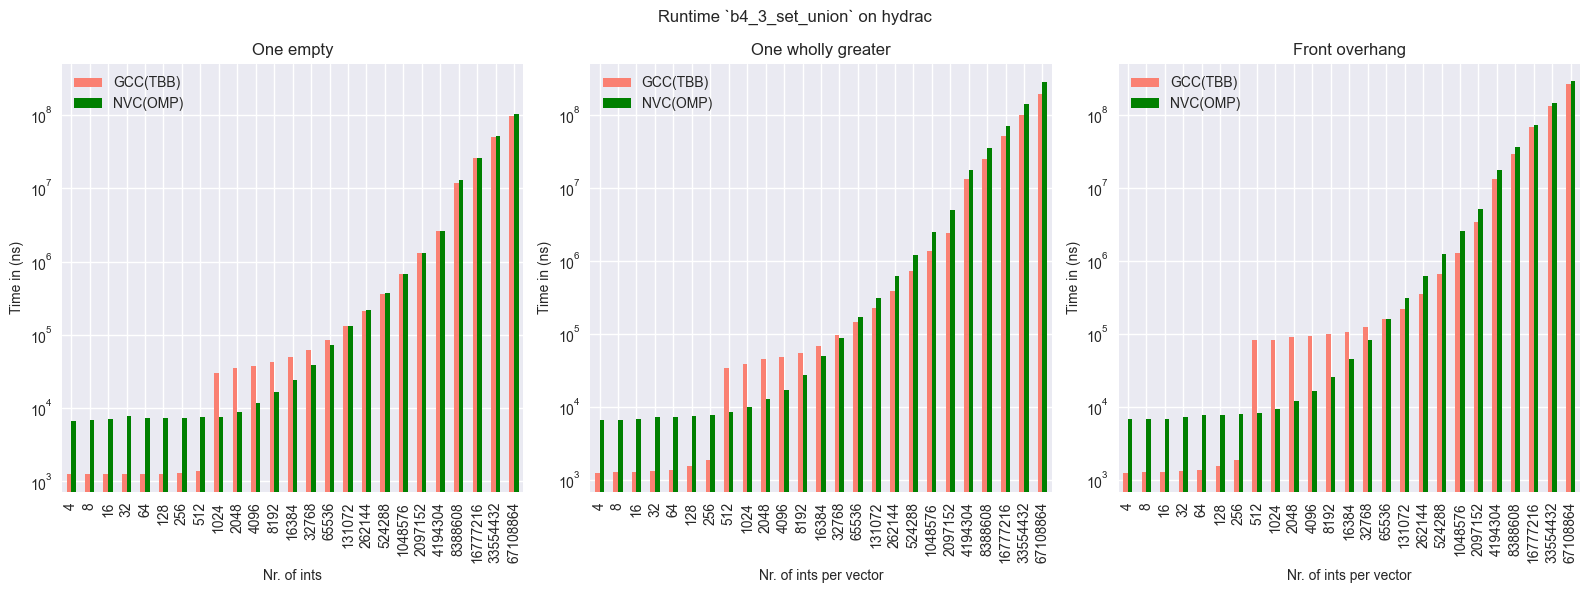

In [104]:
# all set_union graphs

y_lim = 5*pow(10,8)
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('One empty')
ax_1.set_ylim(0,y_lim)

# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Nr. of ints per vector')
ax_2.set_title('One wholly greater')
ax_2.set_ylim(0,y_lim)


# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Front overhang')
ax_3.set_ylim(0,y_lim)

fig.suptitle("Runtime `b4_3_set_union` on hydrac")

fig.tight_layout()

plot("`b4_3_set_union` Runtime on hydrac")

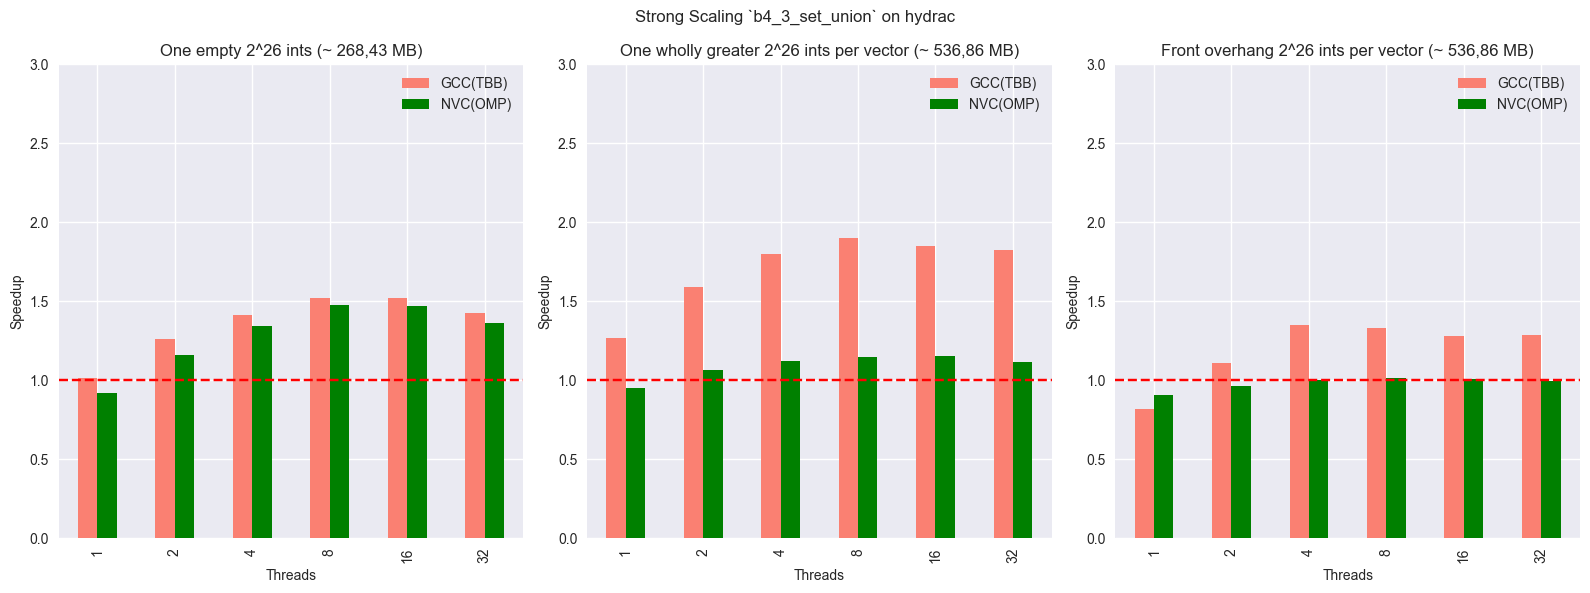

In [105]:
# all set_union graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Threads')
ax_1.set_title('One empty 2^26 ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,3)

# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('One wholly greater 2^26 ints per vector (~ 536,86 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
ax_2.set_ylim(0,3)


# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Threads')
ax_3.set_title('Front overhang 2^26 ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')
ax_3.set_ylim(0,3)


fig.suptitle("Strong Scaling `b4_3_set_union` on hydrac")

fig.tight_layout()

plot("`b4_3_set_union` Strong Scaling on hydrac")

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/1255600599.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/1255600599.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/1255600599.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


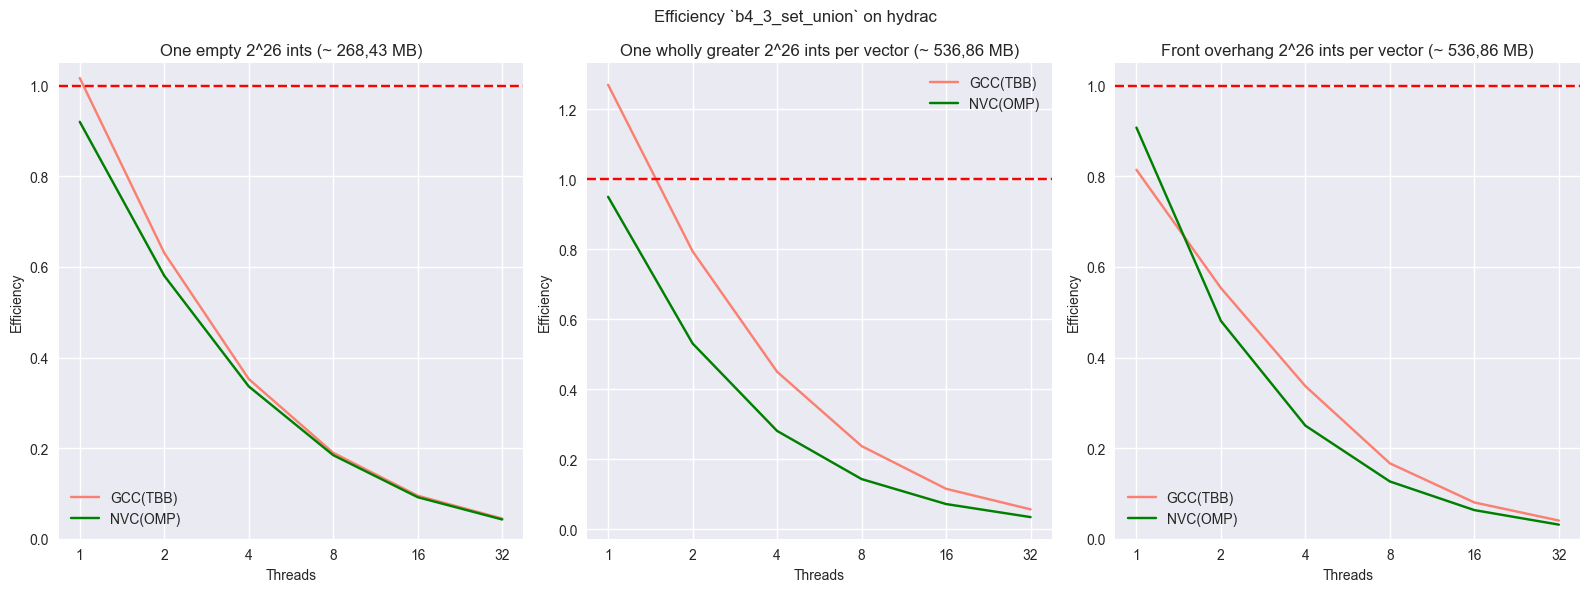

In [106]:
# efficiency  set_union graphs


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Threads')
ax_1.set_title('One empty 2^26 ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Threads')
ax_2.set_title('One wholly greater 2^26 ints per vector (~ 536,86 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
#ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Front overhang 2^26 ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')
ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


fig.suptitle("Efficiency `b4_3_set_union` on hydrac")

fig.tight_layout()

plot("`b4_3_set_union` Efficiency on hydrac")

### Mbytes/s

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/2040074851.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_1.set_ylim(0,2*pow(2,14))
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/2040074851.py:57: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_2.set_ylim(*ylim)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/2040074851.py:72: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_3.set_ylim(*ylim)


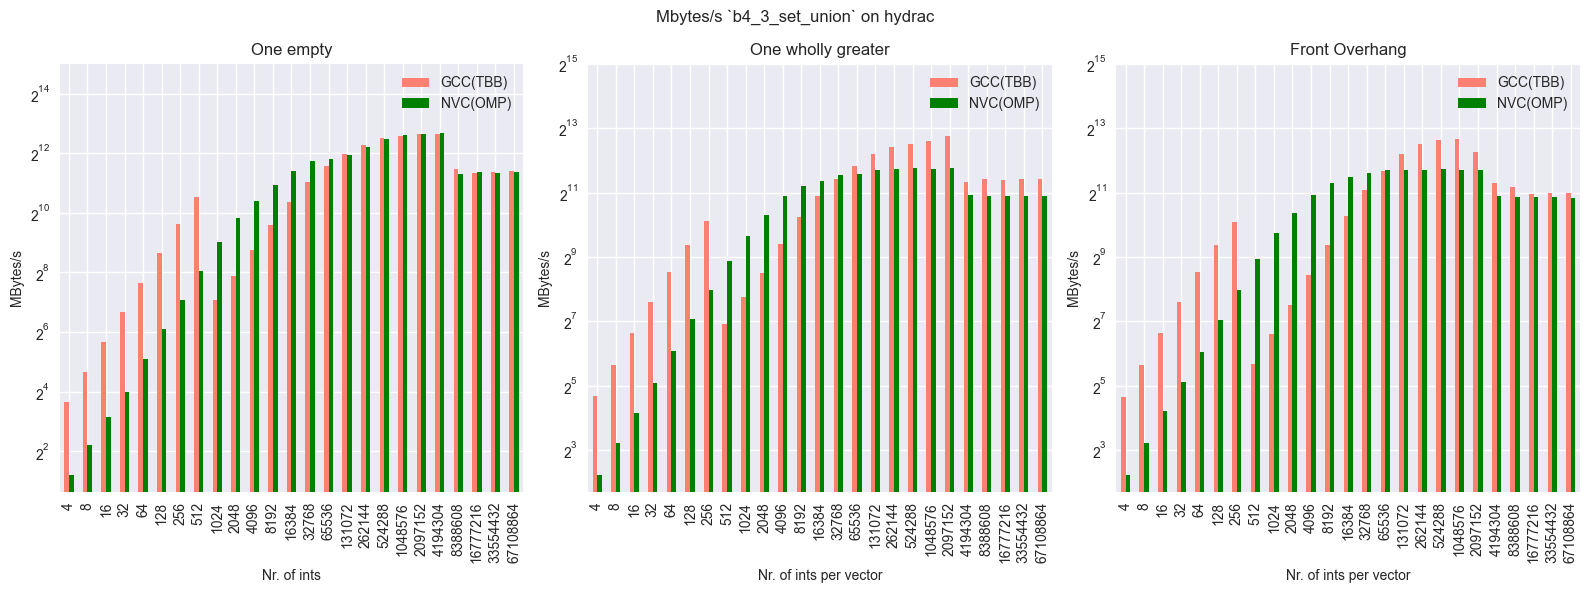

In [107]:
benchmark_names = [
    'b4_3_set_union_cutoff_one_empty_par',
    'b4_3_set_union_cutoff_one_wholly_greater_par',
    'b4_3_set_union_cutoff_front_overhang_par'
]


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

b4_3_mbytes_sec_data = {}

for benchmark_name in benchmark_names:
    # collect data for instances
    data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

    b4_3_mbytes_sec_data[benchmark_name] = pd.merge(*data, on='n')


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))

ylim = (0,pow(2,15))


# plot one empty
ax_1 = b4_3_mbytes_sec_data['b4_3_set_union_cutoff_one_empty_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0]
                                                    )


ax_1.set_yscale('log',base=2)
ax_1.set_ylabel('MBytes/s')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('One empty')
ax_1.set_ylim(0,2*pow(2,14))



# plot wholey greater
ax_2 = b4_3_mbytes_sec_data['b4_3_set_union_cutoff_one_wholly_greater_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )


ax_2.set_yscale('log',base=2)
ax_2.set_ylabel('MBytes/s')
ax_2.set_xlabel('Nr. of ints per vector')
ax_2.set_title('One wholly greater')
ax_2.set_ylim(*ylim)


# plot front_overhang
ax_3 = b4_3_mbytes_sec_data['b4_3_set_union_cutoff_front_overhang_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[2]
                                                    )

ax_3.set_yscale('log',base=2)
ax_3.set_ylabel('MBytes/s')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Front Overhang')
ax_3.set_ylim(*ylim)


fig.suptitle("Mbytes/s `b4_3_set_union` on hydrac")

fig.tight_layout()

plot("`b4_3_set_union` Mbytes_s on hydrac")

## `b4_4_set_difference`

### Time Comparison - `b4_4_set_difference_cutoff_left_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [108]:
def b4_4_set_difference_cutoff_left_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_left_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_left_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_left_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_left_empty_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_left_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,1224.38,4,1231.43
1,1225.95,8,1231.64
2,1225.27,16,1231.86
3,1224.79,32,1232.06
4,1224.81,64,1231.71
5,1225.01,128,1231.42
6,1224.75,256,1231.10
7,1224.32,512,1231.88
8,1224.47,1024,1231.51
9,1224.78,2048,1231.74


### Time Comparison - `b4_4_set_difference_cutoff_right_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [109]:
def b4_4_set_difference_cutoff_right_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_right_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_right_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_right_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_right_empty_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_right_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,3859.73,4,6.601000e+03
1,5774.01,8,7.286890e+03
2,9358.29,16,7.096750e+03
3,14029.50,32,7.411730e+03
4,19285.50,64,7.397020e+03
5,24173.00,128,7.327940e+03
6,27140.30,256,7.381740e+03
7,30184.40,512,7.564000e+03
8,33760.80,1024,7.880510e+03
9,38132.40,2048,9.035650e+03


### Time Comparison - `b4_4_set_difference_cutoff_wholly_greater_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [110]:
def b4_4_set_difference_cutoff_wholly_greater_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_wholly_greater_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_wholly_greater_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_wholly_greater_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_wholly_greater_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_wholly_greater_time_merged

,GCC(TBB),n,NVC(OMP)
0,3835.84,4,1.264710e+03
1,5739.52,8,1.269350e+03
2,9156.76,16,1.277700e+03
3,14319.30,32,1.297000e+03
4,18876.00,64,1.329930e+03
5,23590.00,128,1.404560e+03
6,27420.60,256,1.534910e+03
7,31969.10,512,1.853380e+03
8,34277.10,1024,2.341670e+03
9,37837.80,2048,3.396970e+03


### Time Comparison - `b4_4_set_difference_cutoff_intersected_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [111]:
def b4_4_set_difference_cutoff_intersected_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_intersected_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_intersected_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_intersected_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_intersected_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_intersected_time_merged

,GCC(TBB),n,NVC(OMP)
0,1280.46,4,1.263170e+03
1,1293.42,8,1.266430e+03
2,1320.62,16,1.276620e+03
3,1377.23,32,1.297220e+03
4,1486.66,64,1.329350e+03
5,1744.23,128,1.409860e+03
6,2204.16,256,1.540000e+03
7,79994.90,512,1.857610e+03
8,82696.20,1024,2.354750e+03
9,83709.80,2048,3.461380e+03


### Strong Scaling - `b4_4_set_difference_cutoff_left_empty_par`

1 Million fixed input size with threads 1-64

In [112]:
def get_b4_4_set_difference_cutoff_left_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_left_empty_seq__Default.csv',
                                            COMP=compiler_name)
    
    
    ## b4_4_set_difference_cutoff_left_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_left_empty_par',
                                               [1,2,4,8,16,32],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_left_empty_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_left_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_left_empty_strong_scaling_merged


,threads,GCC(TBB),NVC(OMP)
0,1,1.010494,0.989756
1,2,1.008181,0.989627
2,4,1.010684,0.987768
3,8,1.010800,0.986917
4,16,1.011155,0.989918
5,32,1.008674,0.987367


In [113]:
# efficiency b4_4_set_difference_cutoff_left_empty_par
b4_4_set_difference_cutoff_left_empty_efficiency = b4_4_set_difference_cutoff_left_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_left_empty_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_left_empty_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_left_empty_efficiency['threads']



b4_4_set_difference_cutoff_left_empty_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,1.010494,0.989756
1,2,0.504090,0.494814
2,4,0.252671,0.246942
3,8,0.126350,0.123365
4,16,0.063197,0.061870
5,32,0.031521,0.030855


### Strong Scaling - `b4_4_set_difference_cutoff_right_empty_par`

1 Million fixed input size with threads 1-64

In [114]:
def get_b4_4_set_difference_cutoff_right_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    

    ## seq base
    sq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_right_empty_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## b4_4_set_difference_cutoff_right_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_right_empty_par',
                                               [1,2,4,8,16,32],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_right_empty_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_right_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_right_empty_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.039775,0.922358
1,2,1.262934,1.168431
2,4,1.400239,1.382092
3,8,1.528090,1.460603
4,16,1.511707,1.496197
5,32,1.431436,1.383244


In [115]:
# efficiency b4_4_set_difference_cutoff_right_empty_par
b4_4_set_difference_cutoff_right_empty_efficiency = b4_4_set_difference_cutoff_right_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_right_empty_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_right_empty_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_right_empty_efficiency['threads']



b4_4_set_difference_cutoff_right_empty_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.039775,0.922358
1,2,0.631467,0.584215
2,4,0.350060,0.345523
3,8,0.191011,0.182575
4,16,0.094482,0.093512
5,32,0.044732,0.043226


#### Strong Scaling - `b4_4_set_difference_cutoff_wholly_greater_par`

1 Million fixed input size with threads 1-64

In [116]:
def get_b4_4_set_difference_cutoff_wholly_greater_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_wholly_greater_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## b4_4_set_difference_cutoff_wholly_greater_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_wholly_greater_par',
                                               [1,2,4,8,16,32],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_wholly_greater_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.288236,1.011514
1,2,1.616920,1.013835
2,4,1.848471,1.023813
3,8,1.959861,1.008018
4,16,1.950715,0.998472
5,32,1.790644,1.008420


In [117]:

# efficiency b4_4_set_difference_cutoff_wholly_greater_par
b4_4_set_difference_cutoff_wholly_greater_efficiency = b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_wholly_greater_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_wholly_greater_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_wholly_greater_efficiency['threads']



b4_4_set_difference_cutoff_wholly_greater_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,1.288236,1.011514
1,2,0.808460,0.506917
2,4,0.462118,0.255953
3,8,0.244983,0.126002
4,16,0.121920,0.062405
5,32,0.055958,0.031513


### Strong Scaling - `b4_4_set_difference_cutoff_intersected_par`

1 Million fixed input size with threads 1-64

In [118]:
def get_b4_4_set_difference_cutoff_intersected_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
     ## seq base
    sq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_intersected_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## b4_4_set_difference_cutoff_intersected_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_intersected_par',
                                               [1,2,4,8,16,32],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_intersected_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_intersected_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_intersected_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.990139,0.993657
1,2,1.580489,0.992862
2,4,2.208333,0.994529
3,8,2.766010,1.007508
4,16,3.108831,0.982343
5,32,3.256853,0.994295


In [119]:
# efficiency b4_4_set_difference_cutoff_intersected_par
b4_4_set_difference_cutoff_intersected_efficiency = b4_4_set_difference_cutoff_intersected_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_intersected_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_intersected_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_intersected_efficiency['threads']



b4_4_set_difference_cutoff_intersected_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,0.990139,0.993657
1,2,0.790245,0.496431
2,4,0.552083,0.248632
3,8,0.345751,0.125938
4,16,0.194302,0.061396
5,32,0.101777,0.031072


### Plots

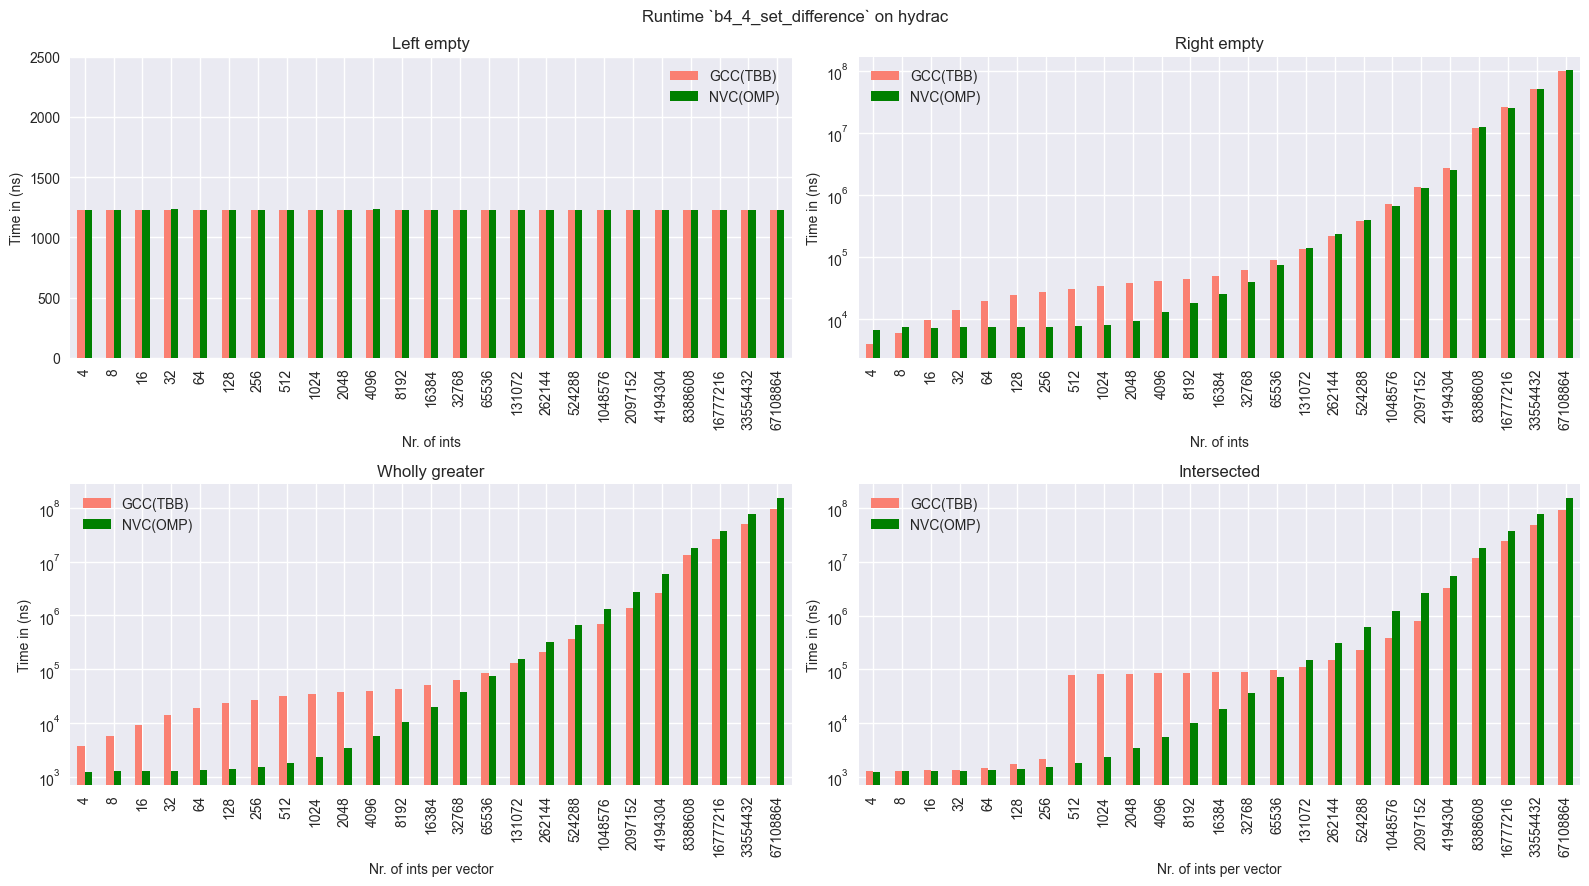

In [120]:
# all set_difference graphs

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Left empty')
ax_1.set_ylim(0,2500)

# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Right empty')


# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Wholly greater')


# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_yscale('log', base=10)
ax_4.set_ylabel('Time in (ns)')
ax_4.set_xlabel('Nr. of ints per vector')
ax_4.set_title('Intersected')

fig.suptitle("Runtime `b4_4_set_difference` on hydrac")

fig.tight_layout()

plot("`b4_4_set_difference` Runtime on hydrac")

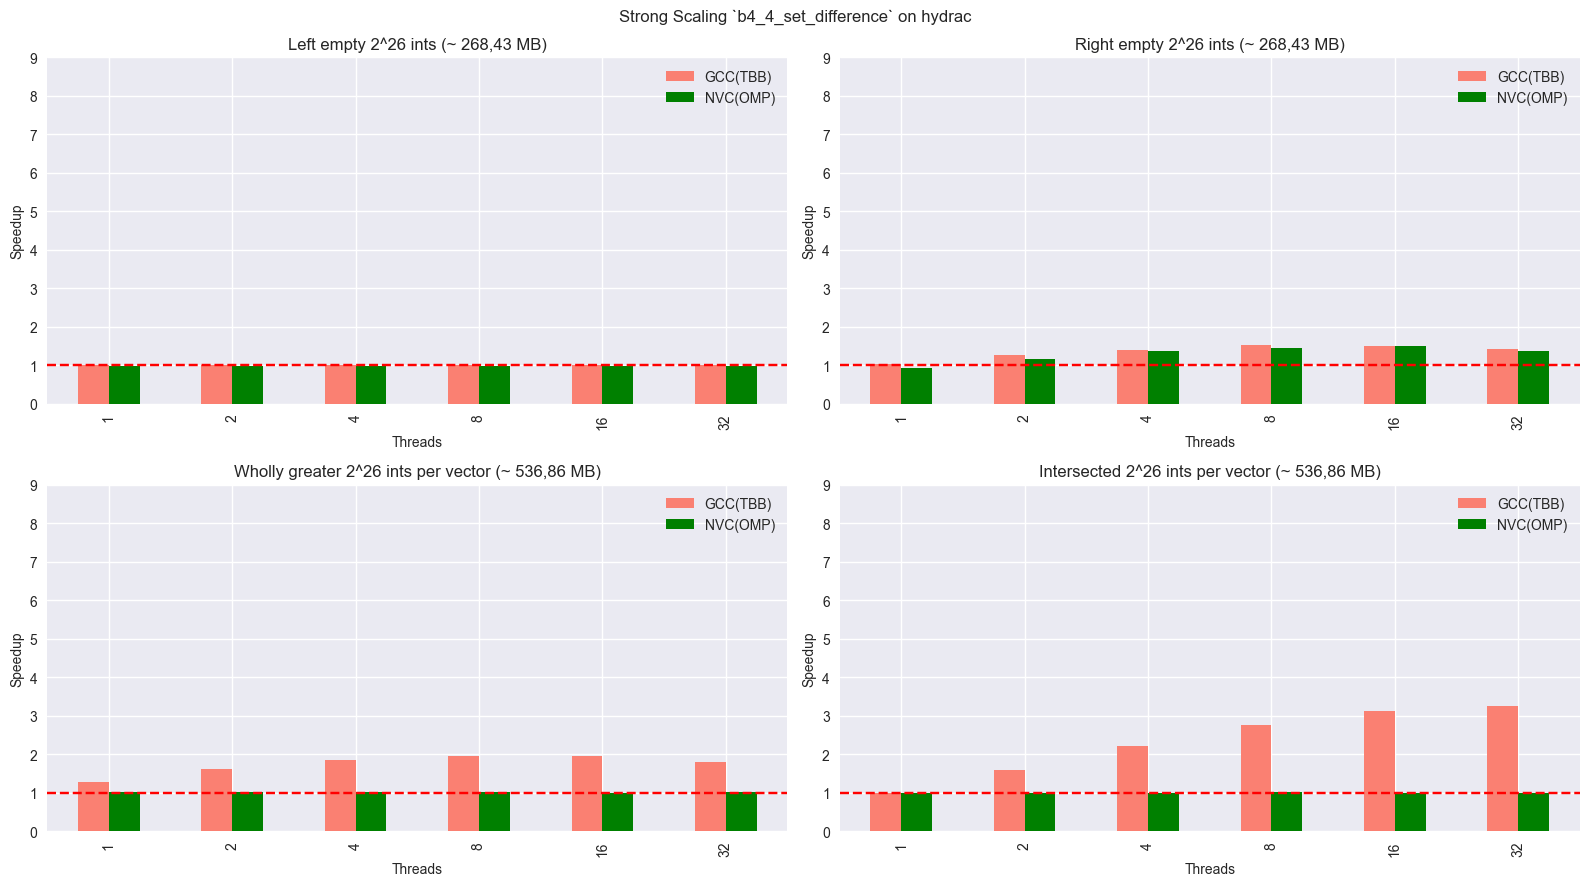

In [121]:
# strong scaling graphs


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Threads')
ax_1.set_title('Left empty 2^26 ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,9)

# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Right empty 2^26 ints (~ 268,43 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
ax_2.set_ylim(0,9)

# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Threads')
ax_3.set_title('Wholly greater 2^26 ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')
ax_3.set_ylim(0,9)

# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_ylabel('Speedup')
ax_4.set_xlabel('Threads')
ax_4.set_title('Intersected 2^26 ints per vector (~ 536,86 MB)')
ax_4.axhline(y=1, color='r',linestyle='--')
ax_4.set_ylim(0,9)

fig.suptitle("Strong Scaling `b4_4_set_difference` on hydrac")

fig.tight_layout()

plot("`b4_4_set_difference` Strong Scaling on hydrac")

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/2963343981.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/2963343981.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/2963343981.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41737/2963343981.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_4.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


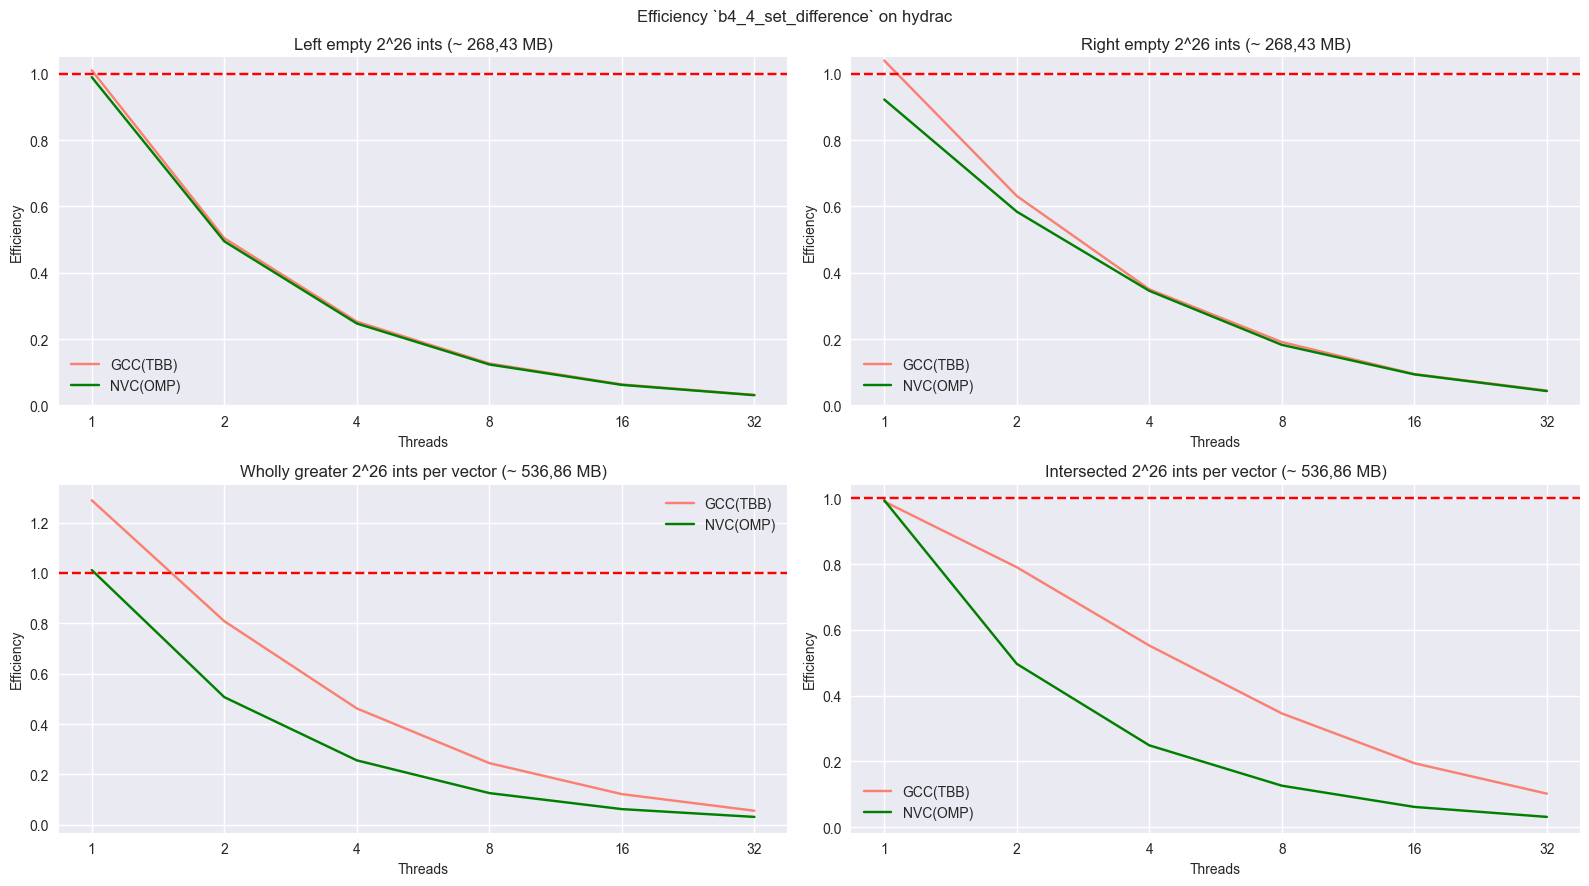

In [122]:
# efficiency graphs


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Threads')
ax_1.set_title('Left empty 2^26 ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Threads')
ax_2.set_title('Right empty 2^26 ints (~ 268,43 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Wholly greater 2^26 ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')


ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_ylabel('Efficiency')
ax_4.set_xlabel('Threads')
ax_4.set_title('Intersected 2^26 ints per vector (~ 536,86 MB)')
ax_4.axhline(y=1, color='r',linestyle='--')


ax_4.set_xscale('log', base=2)
current_values = ax_4.get_xticks()
ax_4.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])




fig.suptitle("Efficiency `b4_4_set_difference` on hydrac")

fig.tight_layout()

plot("`b4_4_set_difference` Efficiency on hydrac")

### Mbytes/s

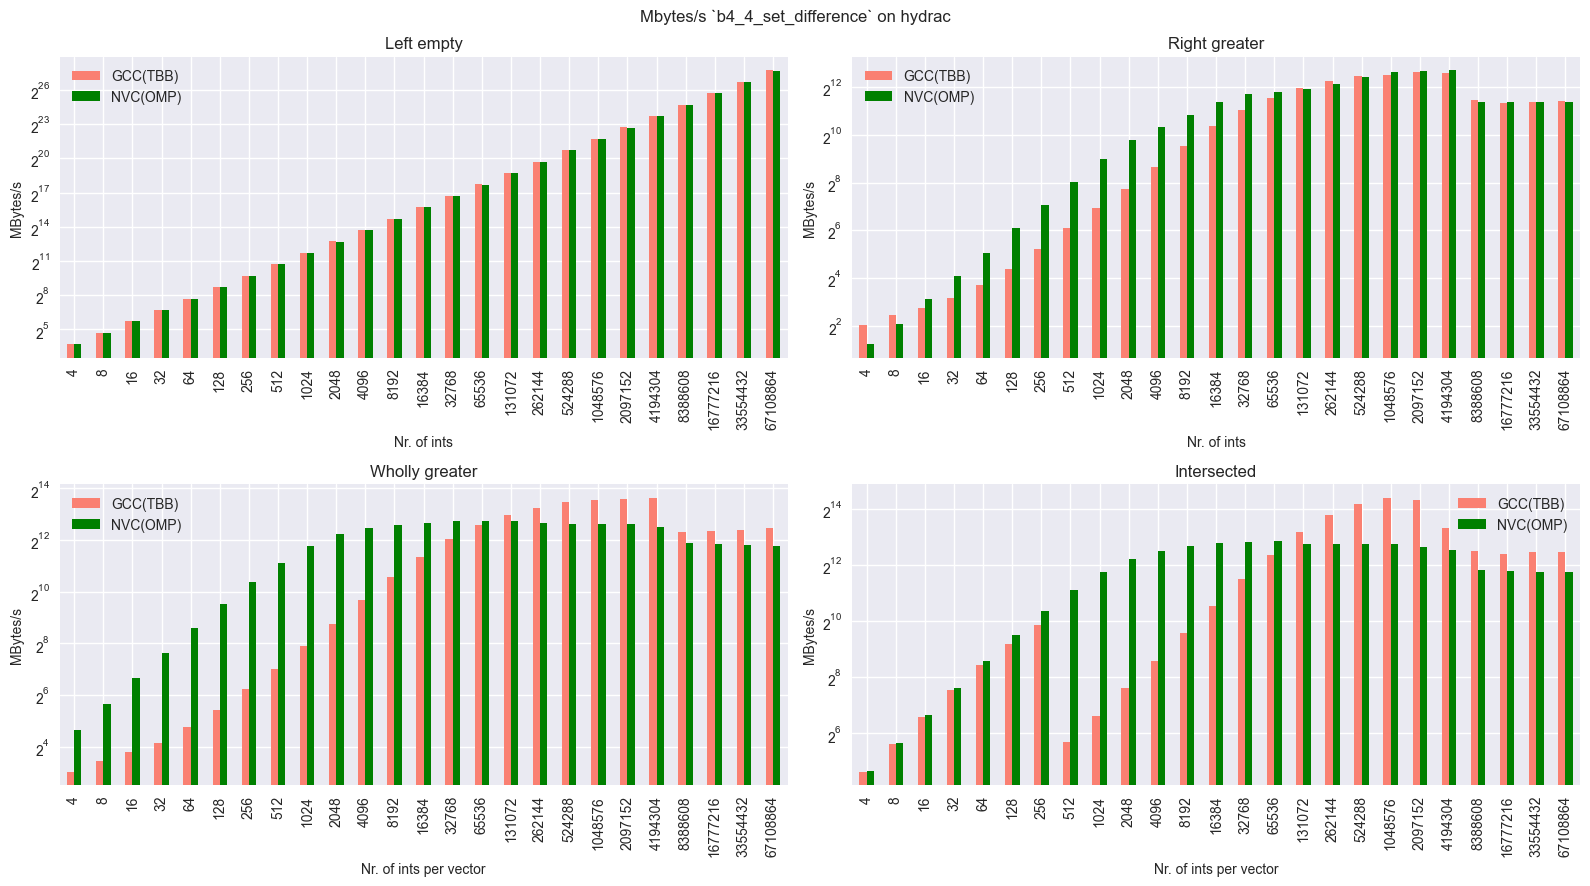

In [123]:
benchmark_names = [
    'b4_4_set_difference_cutoff_left_empty_par',
    'b4_4_set_difference_cutoff_right_empty_par',
    'b4_4_set_difference_cutoff_wholly_greater_par',
    'b4_4_set_difference_cutoff_intersected_par'
]


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

b4_4_mbytes_sec_data = {}

for benchmark_name in benchmark_names:
    # collect data for instances
    data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

    b4_4_mbytes_sec_data[benchmark_name] = pd.merge(*data, on='n')




fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))



# plot left_empty
ax_1 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_left_empty_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0,0]
                                                    )


ax_1.set_yscale('log',base=2)
ax_1.set_ylabel('MBytes/s')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Left empty')




# plot right empty
ax_2 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_right_empty_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0,1]
                                                    )


ax_2.set_yscale('log',base=2)
ax_2.set_ylabel('MBytes/s')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Right greater')


# plot front_overhang
ax_3 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_wholly_greater_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1,0]
                                                    )

ax_3.set_yscale('log',base=2)
ax_3.set_ylabel('MBytes/s')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Wholly greater')



# plot intersected
ax_4 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_intersected_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1,1]
                                                    )

ax_4.set_yscale('log',base=2)
ax_4.set_ylabel('MBytes/s')
ax_4.set_xlabel('Nr. of ints per vector')
ax_4.set_title('Intersected')


fig.suptitle("Mbytes/s `b4_4_set_difference` on hydrac")

fig.tight_layout()

plot("`b4_4_set_difference` Mbytes_s on hydrac")

## Performance Portability Calculation (Inter Compiler)

TODO

In [124]:
def calc_pp(data_points:List[int]) -> int:
    max_val = max(data_points)
    return len(data_points) / sum([1/(val/max_val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('B4_1',b4_1_mbytes_sec_data),
    
    ('B4_2_already_sorted',b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_already_sorted_par']),
    ('B4_2_decrement_sorted',b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_decrement_sorted_par']),
    ('B4_2_not_sorted',b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_not_sorted_par']),
    
    ('b4_3_one_empty',b4_3_mbytes_sec_data['b4_3_set_union_cutoff_one_empty_par']),
    ('b4_3_wholly_greater',b4_3_mbytes_sec_data['b4_3_set_union_cutoff_one_wholly_greater_par']),
    ('b4_3_front_overhang',b4_3_mbytes_sec_data['b4_3_set_union_cutoff_front_overhang_par']),
    
    ('b4_4_left_empty',b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_left_empty_par']),
    ('b4_4_right_empty',b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_right_empty_par']),
    ('b4_4_wholly_greater',b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_wholly_greater_par']),
    ('b4_4_intersected',b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_intersected_par']),
]


for data in data_fields:

    entry_dict = {
        'name': [data[0]],
    }

    vals = []

    for comp in compilers:
        current_val = int(data[1].iloc[-1][comp])
        entry_dict[comp] = [current_val]

        vals.append(current_val)

    entry_dict['PP'] = calc_pp(vals)

    other_df = pd.DataFrame.from_dict(entry_dict)
    pp_df = pd.concat([pp_df,other_df],ignore_index=True)


pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')

pp_df

,name,GCC(TBB),NVC(OMP),PP,INTERPRET
0,B4_1,2708,1662,0.760641,BAD
1,B4_2_already_sorted,5008,388,0.143810,BAD
2,B4_2_decrement_sorted,3357,363,0.195161,BAD
3,B4_2_not_sorted,3397,493,0.253470,BAD
4,b4_3_one_empty,2739,2636,0.980837,GOOD
5,b4_3_wholly_greater,2763,1895,0.813654,BAD
6,b4_3_front_overhang,2026,1827,0.948352,GOOD
7,b4_4_left_empty,218656000,217314000,0.996922,GOOD
8,b4_4_right_empty,2737,2640,0.981960,GOOD
9,b4_4_wholly_greater,5591,3498,0.769722,BAD


## Findings for H4

### Findings `b4_1_merge`



### Findings `b4_2_stable_sort`



### Findings `b4_3_set_union`



### Findings `b4_4_set_difference`



### General



### GPU Findings



### Hypothesis Findings

